In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cmath import nan
import os
import re
import numpy as np 
import pandas as pd
import math
import click
import json

from pymatgen.core import Structure

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
ch4_sigma , ch4_epsilon = 3.73, 148
c_sigma, c_epsilon = 2.8, 27.0
o_sigma, o_epsilon = 3.05, 79.0
uff = pd.read_csv("./ff_data/uff.csv")

In [4]:
threshold = 15

In [5]:
nvt_path = "./nvt_results"
rst_path = "./parse_results_co2"

In [9]:
structure_lst = os.listdir(nvt_path)
structure_lst

['ABETIN_clean', 'ABUWOJ_clean', 'ABEXEN_clean']

In [10]:
structure = structure_lst[0]

# Data preparation

## Get supercell

In [6]:
def get_supercell(structure):
    with open("nvt_results/%s/simulation.input" %structure, "r") as f_input:
        for line in f_input:
            if re.search("UnitCells", line):
                s1, s2, s3 = line.split()[1], line.split()[2], line.split()[3]
    supercell = [int(s1), int(s2), int(s3)]
    return supercell

In [11]:
sc = get_supercell(structure)

In [12]:
sc

[1, 1, 1]

## Get lattice

In [36]:
def get_lattice(structure):
    with open("nvt_results/%s/Movies/System_0/Framework_final.pdb" %structure) as file:
        lines = file.readlines()
        lattice = [float(l) for l in lines[1].split()[1:4]]
        frame_ele = [l.split()[2] for l in lines[2:]]
        frame_pos = [np.array([float(t) for t in l.split()[4:7]]) for l in lines[2:]]
    return lattice, frame_ele, frame_pos

In [37]:
latt, ele, pos = get_lattice(structure)

In [38]:
latt

[26.963, 26.963, 27.537]

In [40]:
len(ele)

784

# read gas pos

In [50]:
with open(os.path.join(nvt_path, "%s/Movies/System_0/Movie_%s_%d.%d.%d_298.000000_0.000000_allcomponents.pdb" %(structure, structure, sc[0], sc[1], sc[2]))) as file:
        data = file.readlines()
        positions = [line.split() for line in data if "ATOM" in line]
        pos_c = [np.array([float(t) for t in l[4:7]]) for l in positions if l[1] == '2']
        pos_o1 = [np.array([float(t) for t in l[4:7]]) for l in positions if l[1] == '1']
        pos_o2 = [np.array([float(t) for t in l[4:7]]) for l in positions if l[1] == '3']
    

# calculate distance

In [58]:
np.array([1, 2, 3]) > np.array([0, 4, 5])

array([ True, False, False])

In [55]:
dist_c = np.array([np.abs([atom-c for atom in pos]) for c in pos_c])

In [57]:
dist_c.shape

(10000, 784, 3)

## Read force field

### Read ff with LB mixing rule

In [10]:
uff = pd.read_csv("ff_data/uff.csv")

In [11]:
uff

,Unnamed: 0,element,epsilon,sigma,lb_sigma,lb_epsilon
0,0,Ac,16.6080,3.0985,3.399618,82.30400
1,1,Ag,18.1178,2.8045,3.234314,83.05890
2,2,Al,254.1520,4.0082,3.866599,201.07600
3,3,Am,7.0458,3.0121,3.351885,77.52290
4,4,Ar,93.1052,3.4460,3.585189,120.55260
...,...,...,...,...,...,...
98,98,Xe,167.0861,3.9235,3.825527,157.54305
99,99,Y,36.2355,2.9801,3.334033,92.11775
100,100,Yb,114.7458,2.9890,3.339007,131.37290
101,101,Zn,62.4056,2.4616,3.030143,105.20280


## Get gas sites

In [67]:
final_cry =  Structure.from_file("nvt_results/%s/Movies/System_0/Framework_0_final.vasp" %structure)

In [33]:
sp_cry = Structure.from_file("nvt_results/%s/Movies/System_0/Framework_0_final_%s_%s_%s_P1.cif" %(structure, sc[0], sc[1], sc[2]))

/home/xiaoqi/anaconda/lib/python3.9/site-packages/pymatgen/io/cif.py:669: UserWarning: A 1-line symmetry op P1 CIF is detected!
  warnings.warn(msg)
/home/xiaoqi/anaconda/lib/python3.9/site-packages/pymatgen/io/cif.py:1155: UserWarning: Issues encountered while parsing CIF: A 1-line symmetry op P1 CIF is detected!
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


In [34]:
un_cry = Structure.from_file("nvt_results/%s/%s.cif" %(structure, structure))


In [35]:
def assign_sigma_epsilon(py_struc, uff):
    site_sigma = [uff.loc[uff["element"] == site.specie.symbol]["lb_sigma"].values for site in py_struc.sites]
    site_epsilon = [uff.loc[uff["element"] == site.specie.symbol]["lb_epsilon"].values for site in py_struc.sites]
    for i in range(len(py_struc.sites)):
        py_struc.sites[i].properties = {"lb_sigma": site_sigma[i], "lb_epsilon": site_epsilon[i], "weight": []}

    return py_struc


In [36]:
assign_sigma_epsilon(un_cry, uff)

Structure Summary
Lattice
    abc : 9.806399999999998 10.6685 13.9712
 angles : 95.30240000000002 110.54600000000002 74.7329
 volume : 1320.3832557017195
      A : 9.182621985018018 0.0 -3.441647053412613
      B : 2.630535822739987 10.291995607170083 -0.9859005818404675
      C : 0.0 0.0 13.9712
PeriodicSite: Co (8.0307, 9.0582, 0.4664) [0.6224, 0.8801, 0.2488]
PeriodicSite: Co (9.0437, 3.9516, 7.0598) [0.8749, 0.3840, 0.7479]
PeriodicSite: Co (4.4306, 3.9122, 8.8343) [0.3736, 0.3801, 0.7512]
PeriodicSite: Co (3.4911, 9.0976, 2.2134) [0.1270, 0.8840, 0.2521]
PeriodicSite: H (9.6675, 7.8970, -1.8658) [0.8330, 0.7673, 0.1258]
PeriodicSite: H (9.4221, 6.5848, 10.2079) [0.8428, 0.6398, 0.9834]
PeriodicSite: H (5.4551, 6.3255, 11.0269) [0.4180, 0.6146, 0.9356]
PeriodicSite: H (5.8370, 7.6367, -1.0588) [0.4231, 0.7420, 0.0808]
PeriodicSite: H (9.5983, 5.0503, 4.2572) [0.9047, 0.4907, 0.5622]
PeriodicSite: H (8.6031, 6.2977, 2.5764) [0.7616, 0.6119, 0.4152]
PeriodicSite: H (5.2630, 6.5550, 4

In [86]:
final_cry.lattice

Lattice
    abc : 29.4192 32.0055 27.942399999985504
 angles : 95.30240000000276 110.54600000001115 74.7329
 volume : 23766.898602616893
      A : 29.4192 0.0 0.0
      B : 8.427660888007434 30.875986821585958 0.0
      C : -9.8066445000486 5.79428151047e-05 26.1650041354

In [37]:
assign_sigma_epsilon(sp_cry, uff)

Structure Summary
Lattice
    abc : 29.4192 32.0055 27.9424
 angles : 95.30240000000002 110.546 74.7329
 volume : 23766.89860263095
      A : 27.547865955054057 0.0 -10.32494116023784
      B : 7.891607468219961 30.875986821510246 -2.9577017455214025
      C : 0.0 0.0 27.9424
PeriodicSite: Co (8.0307, 9.0582, 0.4664) [0.2075, 0.2934, 0.1244]
PeriodicSite: Co (9.0437, 3.9516, 7.0598) [0.2916, 0.1280, 0.3740]
PeriodicSite: Co (4.4306, 3.9122, 8.8343) [0.1245, 0.1267, 0.3756]
PeriodicSite: Co (3.4911, 9.0976, 2.2134) [0.0423, 0.2947, 0.1260]
PeriodicSite: Co (8.0307, 9.0582, 14.4376) [0.2075, 0.2934, 0.6244]
PeriodicSite: Co (9.0437, 3.9516, 21.0310) [0.2916, 0.1280, 0.8740]
PeriodicSite: Co (4.4306, 3.9122, 22.8055) [0.1245, 0.1267, 0.8756]
PeriodicSite: Co (3.4911, 9.0976, 16.1846) [0.0423, 0.2947, 0.6260]
PeriodicSite: Co (10.6613, 19.3502, -0.5195) [0.2075, 0.6267, 0.1244]
PeriodicSite: Co (11.6742, 14.2436, 6.0739) [0.2916, 0.4613, 0.3740]
PeriodicSite: Co (7.0612, 14.2042, 7.8484) [

### Read molecule movies and get the fractional coordinates in the unit cell

In [38]:
with open("nvt_results/%s/Movies/System_0/Movie_%s_%d.%d.%d_298.000000_0.000000_allcomponents.pdb" %(structure, structure, sc[0], sc[1], sc[2])) as file:
    data = file.readlines()
    atom_pos = np.array([np.array([float(i) for i in line.split()[4:7]]) for line in data if "ATOM" in line])

### map the gas molecule coordinates to unit cell

In [99]:
un_cry.lattice

Lattice
    abc : 9.806399999999998 10.6685 13.9712
 angles : 95.30240000000002 110.54600000000002 74.7329
 volume : 1320.3832557017195
      A : 9.182621985018018 0.0 -3.441647053412613
      B : 2.630535822739987 10.291995607170083 -0.9859005818404675
      C : 0.0 0.0 13.9712

In [102]:
sp_cry.lattice = [
                    [29.4192,0.0,0.0], 
                    [8.427660888007434,30.875986821585958,0.0],
                    [-9.8066445000486,5.79428151047e-05,26.1650041354]
]

In [101]:
final_cry

Structure Summary
Lattice
    abc : 29.4192 32.0055 27.942399999985504
 angles : 95.30240000000276 110.54600000001115 74.7329
 volume : 23766.898602616893
      A : 29.4192 0.0 0.0
      B : 8.427660888007434 30.875986821585958 0.0
      C : -9.8066445000486 5.79428151047e-05 26.1650041354
PeriodicSite: Co (7.3562, 9.0582, 3.2552) [0.2075, 0.2934, 0.1244]
PeriodicSite: Co (5.9907, 3.9516, 9.7847) [0.2916, 0.1280, 0.3740]
PeriodicSite: Co (1.0483, 3.9122, 9.8273) [0.1245, 0.1267, 0.3756]
PeriodicSite: Co (2.4922, 9.0976, 3.2978) [0.0423, 0.2947, 0.1260]
PeriodicSite: Co (2.4529, 9.0582, 16.3377) [0.2075, 0.2934, 0.6244]
PeriodicSite: Co (1.0874, 3.9517, 22.8672) [0.2916, 0.1280, 0.8740]
PeriodicSite: Co (-3.8550, 3.9122, 22.9098) [0.1245, 0.1267, 0.8756]
PeriodicSite: Co (-2.4111, 9.0976, 16.3803) [0.0423, 0.2947, 0.6260]
PeriodicSite: Co (10.1654, 19.3502, 3.2552) [0.2075, 0.6267, 0.1244]
PeriodicSite: Co (8.8000, 14.2436, 9.7847) [0.2916, 0.4613, 0.3740]
PeriodicSite: Co (3.8576, 14.2

In [127]:
un_cry.get_sites_in_sphere(pt=atom_pos[4], r=4)

[PeriodicSite: C (24.5547, 10.6368, 15.0737) [2.7840, 1.0335, 1.1522],
 PeriodicSite: C (24.2979, 11.4777, 13.8374) [2.6871, 1.1152, 1.0577],
 PeriodicSite: C (23.9434, 16.4055, 19.0968) [2.7149, 1.5940, 1.4597],
 PeriodicSite: H (24.6704, 16.5897, 18.5144) [2.7616, 1.6119, 1.4152],
 PeriodicSite: H (28.5787, 13.1964, 14.8172) [3.1133, 1.2822, 1.1326],
 PeriodicSite: H (26.2577, 11.7308, 13.2997) [2.8594, 1.1398, 1.0166],
 PeriodicSite: C (25.3618, 11.9408, 13.0639) [2.7532, 1.1602, 0.9986],
 PeriodicSite: H (27.9819, 15.2600, 17.9283) [3.1139, 1.4827, 1.3704]]

In [103]:
sp_cry.sites[62]

PeriodicSite: Co (18.5670, 14.2042, 22.9098) [0.7912, 0.4600, 0.8756]

In [95]:
final_cry.sites[62]

PeriodicSite: Co (18.5670, 14.2042, 22.9098) [0.7912, 0.4600, 0.8756]

In [109]:
final_cry.get_sites_in_sphere(pt=atom_pos[4], r=4)

[PeriodicSite: C (24.5547, 10.6368, 15.0737) [0.9280, 0.3445, 0.5761],
 PeriodicSite: C (24.2979, 11.4777, 13.8374) [0.8957, 0.3717, 0.5289],
 PeriodicSite: C (23.9434, 16.4055, 19.0968) [0.9050, 0.5313, 0.7299],
 PeriodicSite: H (24.6704, 16.5897, 18.5144) [0.9205, 0.5373, 0.7076],
 PeriodicSite: H (28.5787, 13.1964, 14.8172) [1.0378, 0.4274, 0.5663],
 PeriodicSite: C (25.3618, 11.9408, 13.0639) [0.9177, 0.3867, 0.4993],
 PeriodicSite: H (26.2577, 11.7308, 13.2997) [0.9531, 0.3799, 0.5083],
 PeriodicSite: H (27.9819, 15.2600, 17.9283) [1.0380, 0.4942, 0.6852]]

In [110]:
sp_cry.get_sites_in_sphere(pt=atom_pos[4], r=4)

[PeriodicSite: C (24.5547, 10.6368, 15.0737) [0.9280, 0.3445, 0.5761],
 PeriodicSite: C (24.2979, 11.4777, 13.8374) [0.8957, 0.3717, 0.5289],
 PeriodicSite: C (23.9434, 16.4055, 19.0968) [0.9050, 0.5313, 0.7299],
 PeriodicSite: H (24.6704, 16.5897, 18.5144) [0.9205, 0.5373, 0.7076],
 PeriodicSite: H (28.5787, 13.1964, 14.8172) [1.0378, 0.4274, 0.5663],
 PeriodicSite: C (25.3618, 11.9408, 13.0639) [0.9177, 0.3867, 0.4993],
 PeriodicSite: H (26.2577, 11.7308, 13.2997) [0.9531, 0.3799, 0.5083],
 PeriodicSite: H (27.9819, 15.2600, 17.9283) [1.0380, 0.4942, 0.6852]]

In [39]:
# Get atoms in threshold sphere
threshold = 15
sphere_sites = np.array([[site for site in un_cry.get_sites_in_sphere(pt=pos, r=threshold)] for pos in atom_pos], dtype=object)

In [40]:
# Calculate distance between gas and surrounding framework atoms
dist = np.array([np.array([site.distance_from_point(atom_pos[idx]) for site in sphere_sites[idx]]) 
                    for idx in range(len(atom_pos))], dtype=object)

In [41]:
# Calculate LJ potential

def lj(sigma_lb, epsilon_lb, distance):
    #distance_reduced = distance/sigma_lb
    u_lj = 4 * epsilon_lb * ((sigma_lb/distance)**12 - (sigma_lb/distance)**6)
    return u_lj

potential = np.array([np.array([lj(sphere_sites[i][j].properties["lb_sigma"], sphere_sites[i][j].properties["lb_epsilon"], dist[i][j]) 
                for j in range(len(sphere_sites[i]))]).flatten() 
                for i in range(len(atom_pos))], dtype=object)

In [72]:
# for supercell

sp_sphere_sites = np.array([[site for site in final_cry.get_sites_in_sphere(pt=pos, r=threshold)] for pos in atom_pos], dtype=object)
sp_dist = np.array([np.array([site.distance_from_point(atom_pos[idx]) for site in sp_sphere_sites[idx]]) 
                    for idx in range(len(atom_pos))], dtype=object)
sp_potential = np.array([np.array([lj(sp_sphere_sites[i][j].properties["lb_sigma"], sp_sphere_sites[i][j].properties["lb_epsilon"], sp_dist[i][j]) 
                for j in range(len(sp_sphere_sites[i]))]).flatten() 
                for i in range(len(atom_pos))], dtype=object)

In [23]:
po_sigmoid = np.exp(-po_ana/abs(np.min(po_ana))) / np.sum(np.exp(-po_ana/abs(np.min(po_ana))))

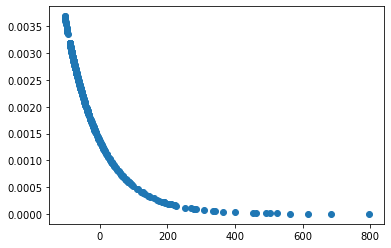

In [24]:
plt.scatter(po_ana, po_sigmoid)

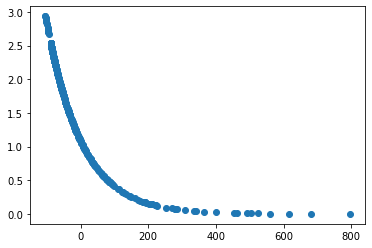

In [25]:
plt.scatter(po_ana, po_sigmoid*abs(po_ana.max()))

# Potential normalization

In [73]:
len(np.hstack(sp_potential))

706882

In [44]:
mins = [po.min() if len(po)!=0 else np.nan for po in potential]
maxs = [po.max() if len(po)!=0 else np.nan for po in potential]
po_norm = np.array([-((po-min)/(max-min)-1) for min, max, po in zip(mins, maxs, potential)], dtype=object)
po_norm = np.hstack(po_norm)

In [78]:
po_norm

array([0.99998939, 0.99998961, 0.99998964, ..., 0.99999793, 0.99999793,
       0.99999793])

In [74]:
# potential normalization for supercell

sp_mins = [po.min() if len(po)!=0 else np.nan for po in sp_potential]
sp_maxs = [po.max() if len(po)!=0 else np.nan for po in sp_potential]
sp_po_norm = np.array([-((po-min)/(max-min)-1) for min, max, po in zip(sp_mins, sp_maxs, sp_potential)], dtype=object)
sp_po_norm = np.hstack(sp_po_norm)

In [79]:
sp_po_norm

array([0.65442995, 0.60304541, 0.60306425, ..., 0.50965477, 0.21264458,
       0.14722526])

## Assign weight to each site

In [61]:
idx = 0
for i in range(sphere_sites.shape[0]):
    for j in range(len(sphere_sites[i])):
        sphere_sites[i][j].properties["weight"].append(po_norm[idx])
        idx += 1
weights = np.array([np.average(site.properties["weight"]) if len(site.properties["weight"])!=0 else 0 
                            for site in un_cry.sites])

In [81]:
# assign weights for supercell
idx = 0
for i in range(sp_sphere_sites.shape[0]):
    for j in range(len(sp_sphere_sites[i])):
        sp_sphere_sites[i][j].properties["weight"].append(sp_po_norm[idx])
        idx += 1
sp_weights = np.array([np.average(site.properties["weight"]) if len(site.properties["weight"])!=0 else 0 
                            for site in final_cry.sites])

In [63]:
weights

array([0.98912228, 0.99088418, 0.98990874, 0.98935675, 0.98962572,
       0.99320695, 0.99140222, 0.98962337, 0.99243849, 0.99190755,
       0.99156405, 0.99124193, 0.99121262, 0.99075962, 0.988453  ,
       0.99204161, 0.9884205 , 0.98886239, 0.98630642, 0.99208974,
       0.99033504, 0.99143185, 0.99326301, 0.99305491, 0.98801803,
       0.99253458, 0.99161763, 0.9906895 , 0.99125795, 0.99097182,
       0.98676009, 0.98913597, 0.99037038, 0.98894871, 0.99267479,
       0.99220769, 0.98853349, 0.98903326, 0.99012763, 0.99128395,
       0.99082272, 0.991482  , 0.98920897, 0.99104204, 0.9923665 ,
       0.99190292, 0.99115947, 0.99162513, 0.99032525, 0.9909412 ,
       0.99179526, 0.99076153, 0.99088301, 0.99120244, 0.99035708,
       0.99096696, 0.99204122, 0.99176458, 0.99251167, 0.9883096 ,
       0.99096248, 0.99035251, 0.99099973, 0.99277071, 0.9928756 ,
       0.98966906, 0.98923596, 0.99315709, 0.99364058, 0.99238219,
       0.99157254, 0.99301263, 0.99163715, 0.99104325, 0.99131

In [82]:
sp_weights

array([0.28407766, 0.27818597, 0.28199413, ..., 0.30029414, 0.27261432,
       0.27847407])

In [28]:
atom_lst = [site.specie.symbol for site in un_cry.sites]

In [29]:
def atom_label(list):
    ele = np.unique(np.array(list))
    list_label = list.copy()
    count = [0] * len(ele)
    for idx in range(len(list)):
        for idj in range(len(ele)):
            if list[idx] == ele[idj]:
                count[idj] += 1
                list_label[idx] = list[idx] + str(count[idj])
    return list_label

In [30]:
atom_lst_test = atom_label(atom_lst)

# Analysis

## Violinplot

In [31]:
key_weight = {}
for idx in range(len(weights)):
    if atom_lst[idx] not in key_weight:
        key_weight.update({atom_lst[idx]: weights[idx]})
    else:
        key_weight[atom_lst[idx]] = np.append(key_weight[atom_lst[idx]], weights[idx])

Text(0, 0.5, 'weight')

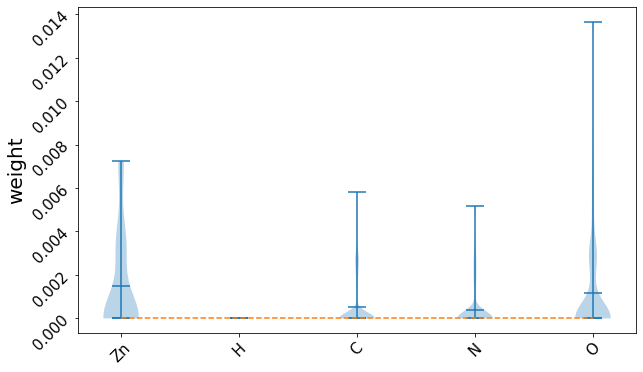

In [32]:
ele = [key for key in key_weight.keys()]
data = [key_weight[key] for key in key_weight.keys()]
pos = np.arange(len(ele))

fs = 15  # fontsize

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

axs.violinplot(data, pos, widths=0.3,
                     showmeans=True, showextrema=True, showmedians=True)
axs.plot([0,len(ele)-1], [0, 0], linestyle='dashed')
axs.set_xticks(np.arange(len(ele)))
axs.set_xticklabels(ele)
axs.tick_params(labelsize=fs, labelrotation=45)
axs.set_ylabel("weight", fontdict={"fontsize": 20})

## cif visualization

In [33]:
from ase_notebook import AseView, ViewConfig
import ase.io

In [34]:
ase_crys = ase.io.read("nvt_results/%s/%s.cif" %(structure, structure))

In [35]:
config = ViewConfig()
config.element_radii = "custom"
config.atom_font_size=12
config.axes_length=30
config.canvas_size=(900, 900)
config.zoom=1.5
config.show_bonds=True

In [36]:
ase_view = AseView(config, radii=weights*10)

radii defined


In [37]:
gui = ase_view.make_render(
    ase_crys, center_in_uc=True)
gui

yes


/home/xiaoqi/anaconda3/envs/ml/lib/python3.7/site-packages/jupyter_client/session.py:716: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


GridspecLayout(children=(Renderer(camera=PerspectiveCamera(fov=10.0, position=(0.0, 0.0, 691.4814299883975), p…

In [27]:
un_cry.sites

[PeriodicSite: Ag (3.4585, 10.3755, 3.0810) [0.2500, 0.7500, 0.5000],
 PeriodicSite: Ag (10.3755, 3.4585, 3.0810) [0.7500, 0.2500, 0.5000],
 PeriodicSite: H (4.0409, 6.0704, 0.6267) [0.2921, 0.4388, 0.1017],
 PeriodicSite: H (5.2542, 5.3275, 2.6078) [0.3798, 0.3851, 0.4232],
 PeriodicSite: H (2.8761, 0.8466, 0.6267) [0.2079, 0.0612, 0.1017],
 PeriodicSite: H (1.6628, 1.5895, 2.6078) [0.1202, 0.1149, 0.4232],
 PeriodicSite: H (0.8466, 4.0409, 0.6267) [0.0612, 0.2921, 0.1017],
 PeriodicSite: H (1.5895, 5.2542, 2.6078) [0.1149, 0.3798, 0.4232],
 PeriodicSite: H (6.0704, 2.8761, 0.6267) [0.4388, 0.2079, 0.1017],
 PeriodicSite: H (5.3275, 1.6628, 2.6078) [0.3851, 0.1202, 0.4232],
 PeriodicSite: H (9.7931, 7.7636, 5.5353) [0.7079, 0.5612, 0.8983],
 PeriodicSite: H (8.5798, 8.5065, 3.5542) [0.6202, 0.6149, 0.5768],
 PeriodicSite: H (10.9579, 12.9874, 5.5353) [0.7921, 0.9388, 0.8983],
 PeriodicSite: H (12.1712, 12.2445, 3.5542) [0.8798, 0.8851, 0.5768],
 PeriodicSite: H (12.9874, 9.7931, 5.535